<a href="https://colab.research.google.com/github/kuds/rl-car-racing/blob/main/%5BCar%20Racing%5D%20Soft%20Actor-Critic%20(SAC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft Actor-Critic (SAC)

In [1]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.9 MB/s eta 0:00:00


In [2]:
!pip install gymnasium gymnasium[box2d] stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl

In [3]:
import gymnasium
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage

import numpy
import platform
import scipy
import stable_baselines3
import IPython
import matplotlib
import matplotlib.pyplot
import torch
import time

In [4]:
print("Python Version: {}".format(platform.python_version()))
print("Is Cuda Available: {}".format(torch.cuda.is_available()))
print("Torch Version: {}".format(torch.__version__))
print("Cuda Version: {}".format(torch.version.cuda))
print("Scipy Version: {}".format(scipy.__version__))
print("Numpy Version: {}".format(numpy.__version__))
print("Stable Baseline Version: {}".format(stable_baselines3.__version__))
print("IPython Version: {}".format(IPython.__version__))
print("Gymnasium Version: {}".format(gymnasium.__version__))

Python Version: 3.10.12
Is Cuda Available: True
Torch Version: 2.3.1+cu121
Cuda Version: 12.1
Scipy Version: 1.13.1
Numpy Version: 1.26.4
Stable Baseline Version: 2.3.2
IPython Version: 7.34.0
Gymnasium Version: 0.29.1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
env = gymnasium.make('CarRacing-v2')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (96, 96, 3)
Action Space Size:  (3,)


In [6]:
# Create Training CarRacing environment
env = make_vec_env("CarRacing-v2", n_envs=1)
env = VecFrameStack(env, n_stack=4)

# Create Elevation CarRacing environment
env_val = make_vec_env("CarRacing-v2", n_envs=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

eval_callback = EvalCallback(env_val,
                             best_model_save_path="./logs/",
                             log_path="./logs/",
                             eval_freq=10000,
                             render=False,
                             n_eval_episodes=20)

# Initialize PPO
model = SAC('CnnPolicy', env, verbose=0)

# Train the model
model.learn(total_timesteps=100000,  progress_bar=True, callback=eval_callback)

# Save the model
model.save("sac_car_racing")

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100,000/100,000  [ 3:12:53 < 0:00:00 , ? it/s ]

Mean reward: -80.07 +/- 1.44


In [7]:
# Create Elevation CarRacing environment
env = make_vec_env("CarRacing-v2", n_envs=1, seed=0)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Load the best model
best_model_path = "./logs/best_model.zip"
best_model = SAC.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/", video_length=10000, record_video_trigger=lambda x: x == 0, name_prefix="best_model_car_racing_sac")

obs = env.reset()
for _ in range(10000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 221.20GB > 29.50GB
  warnings.warn(


Best Model - Mean reward: -21.16 +/- 14.32
Moviepy - Building video /content/videos/best_model_car_racing_sac-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/best_model_car_racing_sac-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_car_racing_sac-step-0-to-step-10000.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


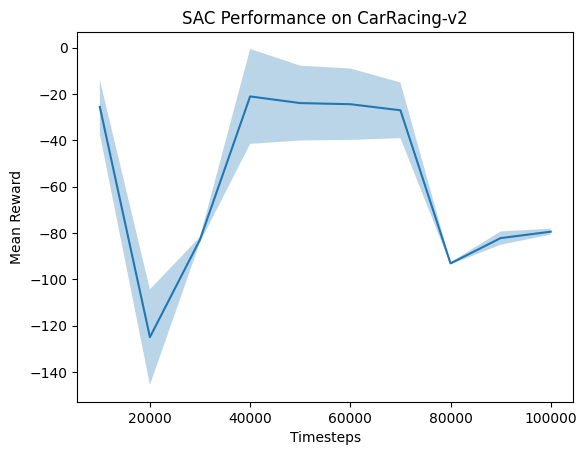

In [8]:
# Load the evaluations.npz file
data = numpy.load('./logs/evaluations.npz')

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps, mean_results - std_results, mean_results + std_results, alpha=0.3)
matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title('SAC Performance on CarRacing-v2')
matplotlib.pyplot.show()